# Reinforcement Learning for Inverted Pendulum Control

## Introduction

The inverted pendulum problem is a classic challenge in the field of control theory and robotics, serving as a fundamental test for various control strategies. In this project, students are required to use reinforcement learning (RL) algorithms to tackle both the single and double inverted pendulum challenges(bonus). You could refer to [inverted_double_pendulum](https://gymnasium.farama.org/environments/mujoco/inverted_double_pendulum/) and [inverted_pendulum](https://gymnasium.farama.org/environments/mujoco/inverted_pendulum/) for details.

### Part 1: Single Inverted Pendulum

**1. Stabilization Task:**

The pendulum starts with a slight inclination.
The goal is to stabilize the pendulum in the upright position by controlling the movement of the cart.
    

![part1](part1.png)

## Training Model

In [14]:
from __future__ import annotations

import numpy as np
import gymnasium as gym
import random
import torch
import torch.nn as nn
from torch.distributions.normal import Normal


## Agent Class

In [15]:
class Agent:
    """Agent that learns to solve the Inverted Pendulum task using a policy gradient algorithm.
    The agent utilizes a policy network to sample actions and update its policy based on
    collected rewards.
    """
    
    def __init__(self, obs_space_dims: int, action_space_dims: int):
        """Initializes the agent with a neural network policy.
        
        Args:
            obs_space_dims (int): Dimension of the observation space.
            action_space_dims (int): Dimension of the action space.
        """
        self.learning_rate = 2e-4  # Learning rate
        self.gamma = 0.99  # Discount factor
        self.eps = 1e-6  # small number for mathematical stability

        self.probs = []  # Stores probability values of the sampled action
        self.rewards = []  # Stores the corresponding rewards

        self.policy_network = Policy_Network(obs_space_dims, action_space_dims)
        self.optimizer = torch.optim.AdamW(self.policy_network.parameters(), lr=self.learning_rate)
    
    def sample_action(self, state: np.ndarray) -> float:
        """Samples an action according to the policy network given the current state.
        
        Args:
            state (np.ndarray): The current state observation from the environment.
        
        Returns:
            float: The action sampled from the policy distribution.
        """
        state = torch.tensor(np.array([state]))
        action_means, action_stddevs = self.policy_network(state)
        
        distrib = Normal(action_means[0] + self.eps, action_stddevs[0] + self.eps)
        action = distrib.sample()               # Action is a PyTorch tensor with shape (1,)
        prob = distrib.log_prob(action)

        action = action.numpy()
        self.probs.append(prob)

        return action  # Return the action
    
    def update(self):
        """Updates the policy network using the REINFORCE algorithm based on collected rewards and log probabilities.
        
        Args:
            rewards (list): Collected rewards from the environment.
            log_probs (list): Log probabilities of the actions taken.
        """
        # The actual implementation of the REINFORCE update will be done here.
        running_g = 0     # Initialize the current cumulative return
        gs = []        # Discounted return

        # Discounted return (backwards)
        for R in self.rewards[::-1]:
            running_g = R + self.gamma * running_g
            gs.insert(0, running_g)

        deltas = torch.tensor(gs)

        # Calculate loss
        loss = 0
        for log_prob, delta in zip(self.probs, deltas):
            loss += log_prob.mean() * delta * (-1)

        # Update the policy network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Empty out all episode related variables
        self.probs = []
        self.rewards = [] 

## Policy Network Class

In [16]:
class Policy_Network(nn.Module):
    """Neural network to parameterize the policy by predicting action distribution parameters."""
    
    def __init__(self, obs_space_dims: int, action_space_dims: int):
        """Initializes layers of the neural network.
        
        Args:
            obs_space_dims (int): Dimension of the observation space.
            action_space_dims (int): Dimension of the action space.
        """
        super().__init__()
        # Define the neural network layers here
        hidden_space1 = 16
        hidden_space2 = 32

        self.fc1 = nn.Linear(obs_space_dims, hidden_space1)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(hidden_space1, hidden_space2)
        self.tanh2 = nn.Tanh()

        self.policy_mean_fc = nn.Linear(hidden_space2, action_space_dims)

        self.policy_stddev_fc = nn.Linear(hidden_space2, action_space_dims)


    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Predicts parameters of the action distribution given the state.
        
        Args:
            x (torch.Tensor): The state observation.
        
        Returns:
            tuple[torch.Tensor, torch.Tensor]: Predicted mean and standard deviation of the action distribution.
        """
        # Implement the prediction logic here
        x = x.float()
        x = self.tanh1(self.fc1(x))
        x = self.tanh2(self.fc2(x))

        action_means = self.policy_mean_fc(x)
        action_stddevs = torch.log(1 + torch.exp(self.policy_stddev_fc(x)))
        return action_means, action_stddevs  

## Set Environment

In [17]:
# Initialize the environment
from env import CustomWrapper
env = gym.make("InvertedPendulum-v4")  
env = CustomWrapper(env)

## Training and Save model

In [18]:
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Wrap the environment to record statistics

obs_space_dims = env.observation_space.shape[0]  # Dimension of the observation space
action_space_dims = env.action_space.shape[0]  # Dimension of the action space
agent = Agent(obs_space_dims, action_space_dims)  # Instantiate the agent

total_num_episodes = int(2338)  # Total number of episodes
reward_threshold = 200000   
# Set seed
seed = 1
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
agent = Agent(obs_space_dims, action_space_dims)

reward_over_episodes = []

# Training loop
for episode in range(total_num_episodes):
    obs, info = wrapped_env.reset(seed=seed)  # Reset the environment at the start of each episode
    done = False
    episode_rewards = []
    episode_log_probs = []
    while not done:
        action = agent.sample_action(obs)  # Sample an action based on the current observation
        obs, reward, terminated, truncated, _ = wrapped_env.step(action)  # Take the action in the environment
        # The collection of rewards and log probabilities should happen within the loop.
        agent.rewards.append(reward)
        episode_rewards.append(reward)
        done = terminated or truncated  # Check if the episode has terminated
    
    total_reward = sum(episode_rewards)
    reward_over_episodes.append(wrapped_env.return_queue[-1])
    agent.update()  # Update the policy based on the episode's experience

    if total_reward >= reward_threshold:
        print(f"Threshold reached at Episode {episode} with Reward: {total_reward}")
        torch.save(agent.policy_network.state_dict(), f"inverted_pendulum_RLmodel_{episode}.pth")
            
        
    if episode % 25 == 0:
        avg_reward = int(np.mean(reward_over_episodes[-50:]))  # Calculate the average reward for the last 50 episodes
        print(f"Episode: {episode}, Average Reward: {avg_reward}")


Episode: 0, Average Reward: -78
Episode: 25, Average Reward: -48
Episode: 50, Average Reward: -44
Episode: 75, Average Reward: -35
Episode: 100, Average Reward: -30
Episode: 125, Average Reward: -31
Episode: 150, Average Reward: -34
Episode: 175, Average Reward: -25
Episode: 200, Average Reward: -15
Episode: 225, Average Reward: -11
Episode: 250, Average Reward: -8
Episode: 275, Average Reward: 5
Episode: 300, Average Reward: 20
Episode: 325, Average Reward: 12
Episode: 350, Average Reward: 8
Episode: 375, Average Reward: 25
Episode: 400, Average Reward: 39
Episode: 425, Average Reward: 49
Episode: 450, Average Reward: 66
Episode: 475, Average Reward: 73
Episode: 500, Average Reward: 77
Episode: 525, Average Reward: 104
Episode: 550, Average Reward: 139
Episode: 575, Average Reward: 153
Episode: 600, Average Reward: 168
Episode: 625, Average Reward: 181
Episode: 650, Average Reward: 212
Episode: 675, Average Reward: 253
Episode: 700, Average Reward: 248
Episode: 725, Average Reward: 26

## Visualization

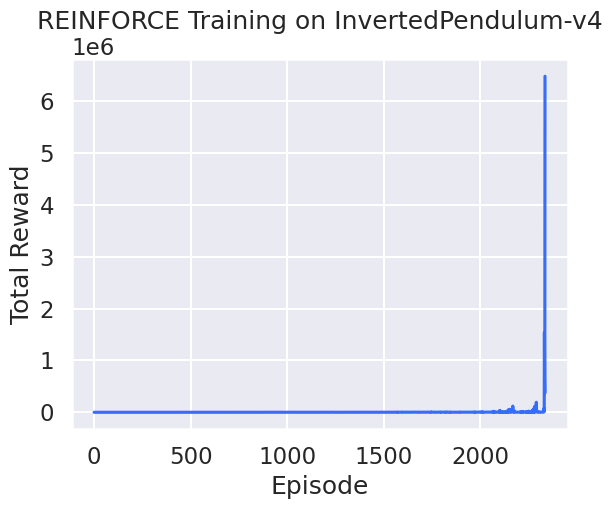

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
reward_over_episodes = [float(reward) for reward in reward_over_episodes]
df = pd.DataFrame({'episodes': range(total_num_episodes), 'reward': reward_over_episodes})
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df).set(
    title="REINFORCE Training on InvertedPendulum-v4",
    xlabel="Episode",
    ylabel="Total Reward"
)
plt.show()